# AN2DL - Second Challenge

## Initial Operations

### Import the libraries

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers

### Set seed for reproducibility

In [ ]:
seed = 69
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Load the dataset

In [ ]:
dataset = pd.read_csv('training.csv')
print(dataset.shape)
dataset.head()

(68528, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672


In [ ]:
dataset.columns 

Index(['Sponginess', 'Wonder level', 'Crunchiness', 'Loudness on impact',
       'Meme creativity', 'Soap slipperiness', 'Hype root'],
      dtype='object')

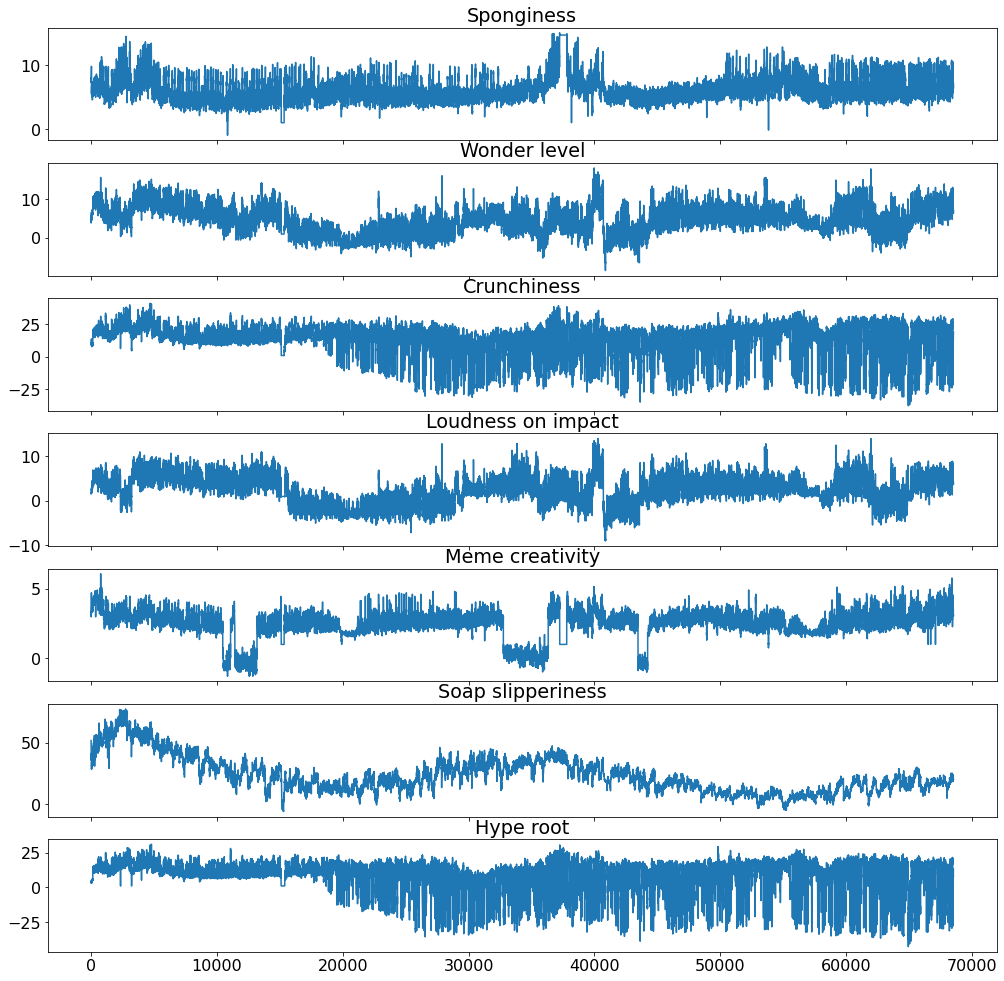

In [ ]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
inspect_dataframe(dataset, dataset.columns)

## Model (Autoregression)

### Train - Test splitting & Normalization

In [ ]:
test_size = 864

X_train_raw = dataset.iloc[:-test_size]
real = dataset[-test_size:]
print(X_train_raw.shape, real.shape)

# Normalize both train and test samples
X_min = X_train_raw.min()
X_max = X_train_raw.max()
X_train_raw = (X_train_raw-X_min)/(X_max-X_min)

(67664, 7) (864, 7)


### Define sequences

In [ ]:
target_labels = dataset.columns
window = 100
stride = 10
telescope = 48

In [ ]:
def build_sequences(df, target_labels, window, stride, telescope):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [ ]:
X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, telescope)

### Define the model

In [ ]:
input_shape = X_train.shape[1:]   #The window 
output_shape = y_train.shape[1:]  #The telescope 
batch_size = 64
epochs = 200
print(input_shape)
print(output_shape)

(100, 7)
(48, 7)


In [ ]:
# #Original One

# def build_CONV_LSTM_model(input_shape, output_shape):
#     # Build the neural network layer by layer
#     input_layer = tfkl.Input(shape=input_shape, name='Input')

#     convlstm = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True))(input_layer)
#     convlstm = tfkl.Conv1D(128, 3, padding='same', activation='relu')(convlstm)
#     convlstm = tfkl.MaxPool1D()(convlstm)
#     convlstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(convlstm)
#     convlstm = tfkl.Conv1D(256, 3, padding='same', activation='relu')(convlstm)
#     convlstm = tfkl.GlobalAveragePooling1D()(convlstm)
#     convlstm = tfkl.Dropout(.5)(convlstm)

#     # In order to predict the next values for more than one channel,
#     # we can use a Dense layer with a number given by telescope*num_channels,
#     # followed by a Reshape layer to obtain a tensor of dimension 
#     # [None, telescope, num_channels]
#     dense = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu')(convlstm)
#     output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)
#     output_layer = tfkl.Conv1D(output_shape[-1], 1, padding='same')(output_layer)

#     # Connect input and output through the Model class
#     model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

#     # Compile the model
#     model.compile(loss=tfk.losses.MeanAbsoluteError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

#     # Return the model
#     return model

In [ ]:
# model = build_CONV_LSTM_model(input_shape, output_shape)
# model.summary()
# tfk.utils.plot_model(model)

In [ ]:
def build_model(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    layer = tfkl.Bidirectional(tfkl.GRU(64, return_sequences=True))(input_layer)
    layer = tfkl.Conv1D(64, 3, padding='same', activation='relu')(layer)
    layer = tfkl.MaxPool1D()(layer)
    layer = tfkl.Bidirectional(tfkl.GRU(128, return_sequences=True))(layer)
    layer = tfkl.Conv1D(128, 6, padding='same', activation='relu')(layer)
    layer = tfkl.MaxPool1D()(layer)
    layer = tfkl.Bidirectional(tfkl.GRU(256, return_sequences=True))(layer)
    layer = tfkl.Conv1D(256, 12, padding='same', activation='relu')(layer)
    layer = tfkl.GlobalAveragePooling1D()(layer)
    layer = tfkl.Dropout(.25)(layer)
    dense = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu')(layer)
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)
    output_layer = tfkl.Conv1D(output_shape[-1], 1, padding='same')(output_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    # Return the model
    return model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 100, 7)]          0         
                                                                 
 bidirectional (Bidirectiona  (None, 100, 128)         28032     
 l)                                                              
                                                                 
 conv1d (Conv1D)             (None, 100, 64)           24640     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 50, 64)           0         
 )                                                               
                                                                 
 bidirectional_1 (Bidirectio  (None, 50, 256)          148992    
 nal)                                                            
                                                             

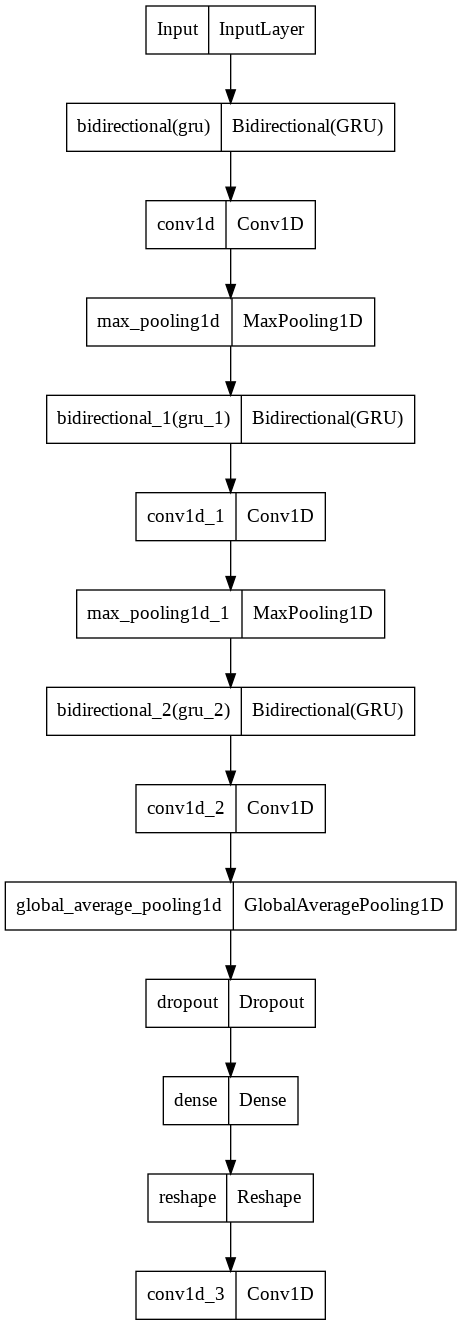

In [ ]:
model = build_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        #tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
95/95 [==============================] - 22s 47ms/step - loss: 0.0772 - mae: 0.2147 - val_loss: 0.0278 - val_mae: 0.1299 - lr: 0.0010
Epoch 2/200
95/95 [==============================] - 3s 28ms/step - loss: 0.0204 - mae: 0.1111 - val_loss: 0.0215 - val_mae: 0.1131 - lr: 0.0010
Epoch 3/200
95/95 [==============================] - 3s 28ms/step - loss: 0.0168 - mae: 0.1003 - val_loss: 0.0186 - val_mae: 0.1040 - lr: 0.0010
Epoch 4/200
95/95 [==============================] - 3s 28ms/step - loss: 0.0149 - mae: 0.0948 - val_loss: 0.0161 - val_mae: 0.0940 - lr: 0.0010
Epoch 5/200
95/95 [==============================] - 3s 28ms/step - loss: 0.0139 - mae: 0.0914 - val_loss: 0.0154 - val_mae: 0.0930 - lr: 0.0010
Epoch 6/200
95/95 [==============================] - 3s 28ms/step - loss: 0.0131 - mae: 0.0884 - val_loss: 0.0148 - val_mae: 0.0894 - lr: 0.0010
Epoch 7/200
95/95 [==============================] - 3s 28ms/step - loss: 0.0126 - mae: 0.0867 - val_loss: 0.0161 - val_mae: 0.09

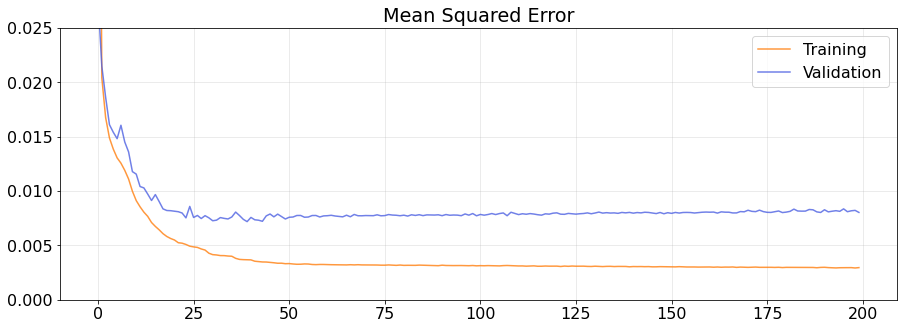

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.ylim(0, 0.025)
plt.title('Mean Squared Error')
plt.legend(loc='upper right')
plt.grid(alpha=.3)
plt.show()

In [ ]:
history['val_mae']

[0.1299201101064682,
 0.1130947545170784,
 0.10400795191526413,
 0.09402409195899963,
 0.09296563267707825,
 0.08940761536359787,
 0.09803695976734161,
 0.09085020422935486,
 0.08540884405374527,
 0.07997715473175049,
 0.07758348435163498,
 0.07382805645465851,
 0.07259796559810638,
 0.07234829664230347,
 0.06911183148622513,
 0.07058579474687576,
 0.06951310485601425,
 0.06402991712093353,
 0.06320788711309433,
 0.06348252296447754,
 0.06397219002246857,
 0.06184651702642441,
 0.061950892210006714,
 0.060493506491184235,
 0.06376847624778748,
 0.06072939187288284,
 0.06205645576119423,
 0.059650737792253494,
 0.061497386544942856,
 0.06039079278707504,
 0.05996013060212135,
 0.05933435633778572,
 0.05959717184305191,
 0.06041131168603897,
 0.05942355468869209,
 0.06114395335316658,
 0.06137795373797417,
 0.060807473957538605,
 0.05919182673096657,
 0.058608513325452805,
 0.05991940200328827,
 0.05916232243180275,
 0.058948587626218796,
 0.05874400958418846,
 0.061081934720277786,
 0.0

### Second Model 

In [ ]:
target_labels = dataset.columns
window = 200
stride = 20
telescope = 54

In [ ]:
X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, telescope)

In [ ]:
input_shape = X_train.shape[1:]   #The window 
output_shape = y_train.shape[1:]  #The telescope 
batch_size = 64
epochs = 200
print(input_shape)
print(output_shape)

(200, 7)
(54, 7)


In [ ]:
model2 = build_model(input_shape, output_shape)

In [ ]:
# Train the model
history = model2.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        #tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
48/48 [==============================] - 23s 266ms/step - loss: 0.1026 - mae: 0.2544 - val_loss: 0.0379 - val_mae: 0.1520 - lr: 0.0010
Epoch 2/200
48/48 [==============================] - 9s 193ms/step - loss: 0.0305 - mae: 0.1368 - val_loss: 0.0229 - val_mae: 0.1117 - lr: 0.0010
Epoch 3/200
48/48 [==============================] - 9s 194ms/step - loss: 0.0210 - mae: 0.1129 - val_loss: 0.0189 - val_mae: 0.1009 - lr: 0.0010
Epoch 4/200
48/48 [==============================] - 9s 194ms/step - loss: 0.0186 - mae: 0.1056 - val_loss: 0.0190 - val_mae: 0.1029 - lr: 0.0010
Epoch 5/200
48/48 [==============================] - 9s 193ms/step - loss: 0.0175 - mae: 0.1023 - val_loss: 0.0185 - val_mae: 0.0970 - lr: 0.0010
Epoch 6/200
48/48 [==============================] - 9s 193ms/step - loss: 0.0169 - mae: 0.1003 - val_loss: 0.0184 - val_mae: 0.0973 - lr: 0.0010
Epoch 7/200
48/48 [==============================] - 9s 193ms/step - loss: 0.0165 - mae: 0.0990 - val_loss: 0.0184 - val_ma

### Predict the last 864
We do this step to have an idea of how the model perform on a interval that corresponds to the one that we really have to predict.

In [ ]:
model = tf.keras.models.load_model('baseline_model.hdf5')
model1 = tf.keras.models.load_model('univariate_Sponginess.hdf5')
model2 = tf.keras.models.load_model('univariate_Wonder level.hdf5')
model3 = tf.keras.models.load_model('univariate_Crunchiness.hdf5')
model4 = tf.keras.models.load_model('univariate_Loudness on impact.hdf5')
model5 = tf.keras.models.load_model('univariate_Meme creativity.hdf5')
model6 = tf.keras.models.load_model('univariate_Soap slipperiness.hdf5')
model7 = tf.keras.models.load_model('univariate_Hype root.hdf5')

In [ ]:
window = 100
stride = 10
telescope = 48
pred_horizon = 864

models = [model1,model2,model3,model4,model5,model6,model7]

# Creating a list of outputs for each univariate model 
outputs = []

X = tf.constant(dataset)
X = X.numpy()

# Autoregressive forecasting for the multivariate model 
future = X[-window-864:-864]
X_min = X.min(axis=0)
X_max = X.max(axis=0)
future = (future-X_min)/(X_max-X_min)
future = np.expand_dims(future,0)
out_mult = np.array([])
for i in range(0, pred_horizon, telescope):
    current_prediction = model.predict(future)
    if(len(out_mult) == 0):
        out_mult = current_prediction
    else:
        out_mult = np.concatenate((out_mult,current_prediction),axis=1)
    future = np.concatenate((future[:,telescope:,:],current_prediction), axis=1)
out_mult = np.squeeze(out_mult,0)
out_mult = out_mult * (X_max - X_min) + X_min

# For each instance of the for cycle we do the prediction of the univariate model
for j in range(7):

    X_univ = X[:,j]
    future = X_univ[-window:]
    future = np.expand_dims(future,1)
    X_min_univ = X_univ.min(axis=0)
    X_max_univ = X_univ.max(axis=0)
    future = (future-X_min_univ)/(X_max_univ-X_min_univ)
    future = np.expand_dims(future,0)
    out = np.array([])
    for i in range(0, pred_horizon, telescope):
        current_prediction = models[j].predict(future)
        if(len(out) == 0):
            out = current_prediction
        else:
            out = np.concatenate((out,current_prediction),axis=1)
        future = np.concatenate((future[:,telescope:,:],current_prediction), axis=1)
    out = np.squeeze(out,0)
    out = out * (X_max_univ - X_min_univ) + X_min_univ
    out = np.squeeze(out,1)
    # Append the output in the list 
    outputs.append(out)

# Substituting the univariate model outputs, which perform better, to the multivariate model outputs
out_mult[:,0] = outputs[0]
out_mult[:,3] = outputs[3]
out_mult[:,4] = outputs[4]


In [ ]:
window = 100
stride = 10
telescope = 48

# Autoregressive Forecasting
X = tf.constant(dataset) # This is NOT for submit
X = X.numpy()
future = X[-(window+864):-864]
X_min = X.min(axis=0)
X_max = X.max(axis=0)
future = (future-X_min)/(X_max-X_min)
future = np.expand_dims(future,0)
pred_horizon = 864
out = np.array([])
for i in range(0, pred_horizon, telescope):
    current_prediction = model.predict(future)
    if(len(out) == 0):
        out = current_prediction
    else:
        out = np.concatenate((out,current_prediction),axis=1)
    future = np.concatenate((future[:,telescope:,:],current_prediction), axis=1)
out = np.squeeze(out,0)
out = out * (X_max - X_min) + X_min
# out = tf.convert_to_tensor(out)

In [ ]:
window = 200
stride = 20
telescope = 54

# Autoregressive Forecasting
X = tf.constant(dataset) # This is NOT for submit
X = X.numpy()
future = X[-(window+864):-864]
X_min = X.min(axis=0)
X_max = X.max(axis=0)
future = (future-X_min)/(X_max-X_min)
future = np.expand_dims(future,0)
pred_horizon = 864
out2 = np.array([])
for i in range(0, pred_horizon, telescope):
    current_prediction = model2.predict(future)
    if(len(out2) == 0):
        out2 = current_prediction
    else:
        out2 = np.concatenate((out2,current_prediction),axis=1)
    future = np.concatenate((future[:,telescope:,:],current_prediction), axis=1)
out2 = np.squeeze(out2,0)
out2 = out2 * (X_max - X_min) + X_min
# out = tf.convert_to_tensor(out)

In [ ]:
out[:,0] = out2[:,0]
out[:,1] = out2[:,1]
out[:,3] = out2[:,3]
out[:,5] = out2[:,5]

In [ ]:
future = X[-(window+864):-864]
future = np.expand_dims(future,0)
real = tf.constant(real) # This is NOT for submit
real = real.numpy()
real

array([[ 5.75257986,  5.22470013, 14.34308018, ...,  2.76955997,
        16.41476042,  9.61208034],
       [ 5.80404009,  5.00226002, 14.23186032, ...,  2.71976002,
        16.41476042,  9.37636001],
       [ 5.70277991,  5.00226002, 13.78698011, ...,  2.76955997,
        16.41476042,  9.14063968],
       ...,
       [ 6.76351981,  7.00422017, 17.23314047, ...,  3.12314007,
        20.38548075, 11.5592601 ],
       [ 6.86477999,  6.67055982, 17.90045959, ...,  3.12314007,
        19.80116035, 12.03069997],
       [ 7.16856013,  7.11544003, 19.23509943, ...,  3.07333992,
        19.91735985, 13.15120028]])

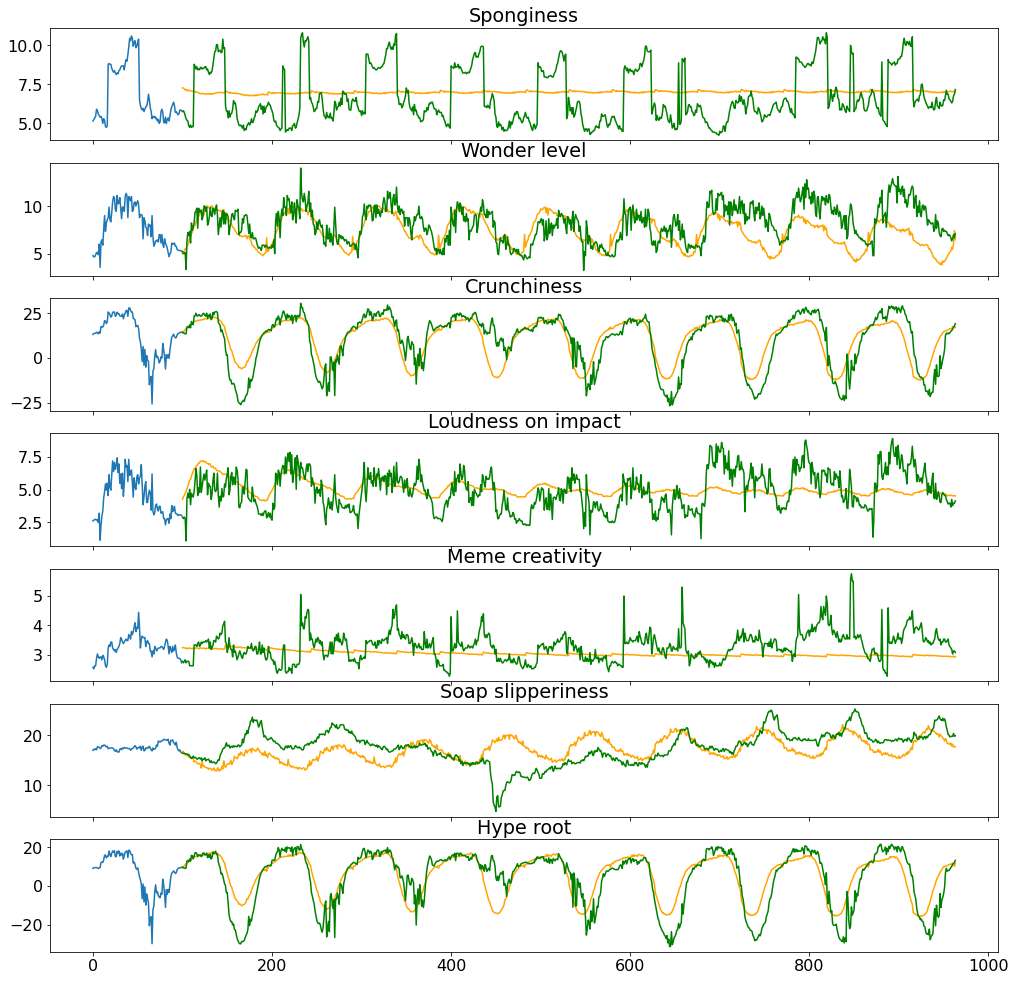

In [ ]:
target_labels = dataset.columns
figs, axs = plt.subplots(len(target_labels), 1, sharex=True, figsize=(17,17))
for i, col in enumerate(target_labels):
    axs[i].plot(np.arange(len(future[0,:,i])), future[0,:,i])
    axs[i].plot(np.arange(len(future[0,:,i]), len(future[0,:,i])+pred_horizon), out_mult[:,i], color='orange')
    axs[i].plot(np.arange(len(future[0,:,i]), len(future[0,:,i])+pred_horizon), real[:,i], color='green')
    axs[i].set_title(col)
    # axs[i].set_ylim(0,1)
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

mean_squared_error(real,out_mult,squared=True,multioutput='uniform_average')

24.262304637884068

In [ ]:
pred_horizon = 864
telescope = 48
window = 100
telescope2 = 54
window2 = 200

future = X[-window:]
X_min = X.min(axis=0)
X_max = X.max(axis=0)
future = (future-X_min)/(X_max-X_min)
future = np.expand_dims(future,0)
out = np.array([])
for i in range(0, pred_horizon, telescope):
    current_prediction = model.predict(future)
    if(len(out) == 0):
        out = current_prediction
    else:
        out = np.concatenate((out,current_prediction),axis=1)
    future = np.concatenate((future[:,telescope:,:],current_prediction), axis=1)
out = np.squeeze(out,0)
out = out * (X_max - X_min) + X_min

# Autoregressive prediction (Model 2)
future = X[-window2:]
X_min = X.min(axis=0)
X_max = X.max(axis=0)
future = (future-X_min)/(X_max-X_min)
future = np.expand_dims(future,0)
out2 = np.array([])
for i in range(0, pred_horizon, telescope2):
    current_prediction = model2.predict(future)
    if(len(out2) == 0):
        out2 = current_prediction
    else:
        out2 = np.concatenate((out2,current_prediction),axis=1)
    future = np.concatenate((future[:,telescope2:,:],current_prediction), axis=1)
out2 = np.squeeze(out2,0)
out2 = out2 * (X_max - X_min) + X_min

# Substitute univariate prediction in the joint model
out[:, 0] = out2[:, 0]
out[:, 1] = out2[:, 1]
out[:, 3] = out2[:, 3]
out[:, 5] = out2[:, 5]


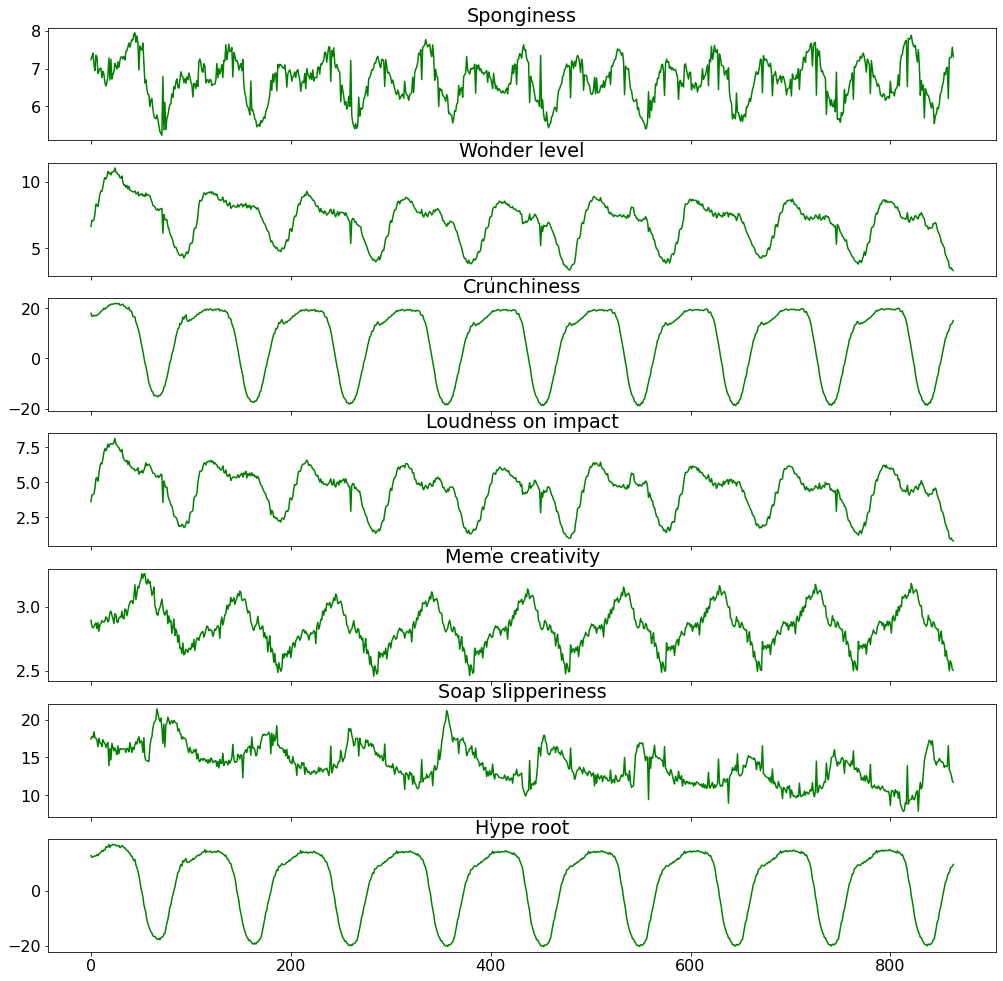

In [ ]:
figs, axs = plt.subplots(len(target_labels), 1, sharex=True, figsize=(17,17))
for i, col in enumerate(target_labels):
    axs[i].plot(out[:,i], color='green')
    axs[i].set_title(col)
    # axs[i].set_ylim(0,1)
plt.show()